# Case assingment - Forecast

## Data loading /prep

In [400]:
# Import packages
import pandas as pd

### Dataset for Residental Demand South Carolina

In [401]:
# Import data
df_demand = pd.read_csv(r"C:\Users\jg\code\templat_reg_and_class\data\Residential Demand South Carolina.csv", header=None)

# Define column names and add them to the dataframe
column_names = ["datetime", "gas_demand_month"]
df_demand.columns = column_names

# Print info about dataframe
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   datetime          48 non-null     object
 1   gas_demand_month  48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


### Dataset for temperature for South Carolina

In [402]:
# Import data
df_temp = pd.read_csv(r"C:\Users\jg\code\templat_reg_and_class\data\Temperatures South Carolina.csv", header=None)

# Define column names and add them to the dataframe
column_names = ["datetime", "temperature_day"]
df_temp.columns = column_names

# Print info about dataframe
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         1551 non-null   object 
 1   temperature_day  1551 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.4+ KB


## Statistics, plotting and more data prep

### Gas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


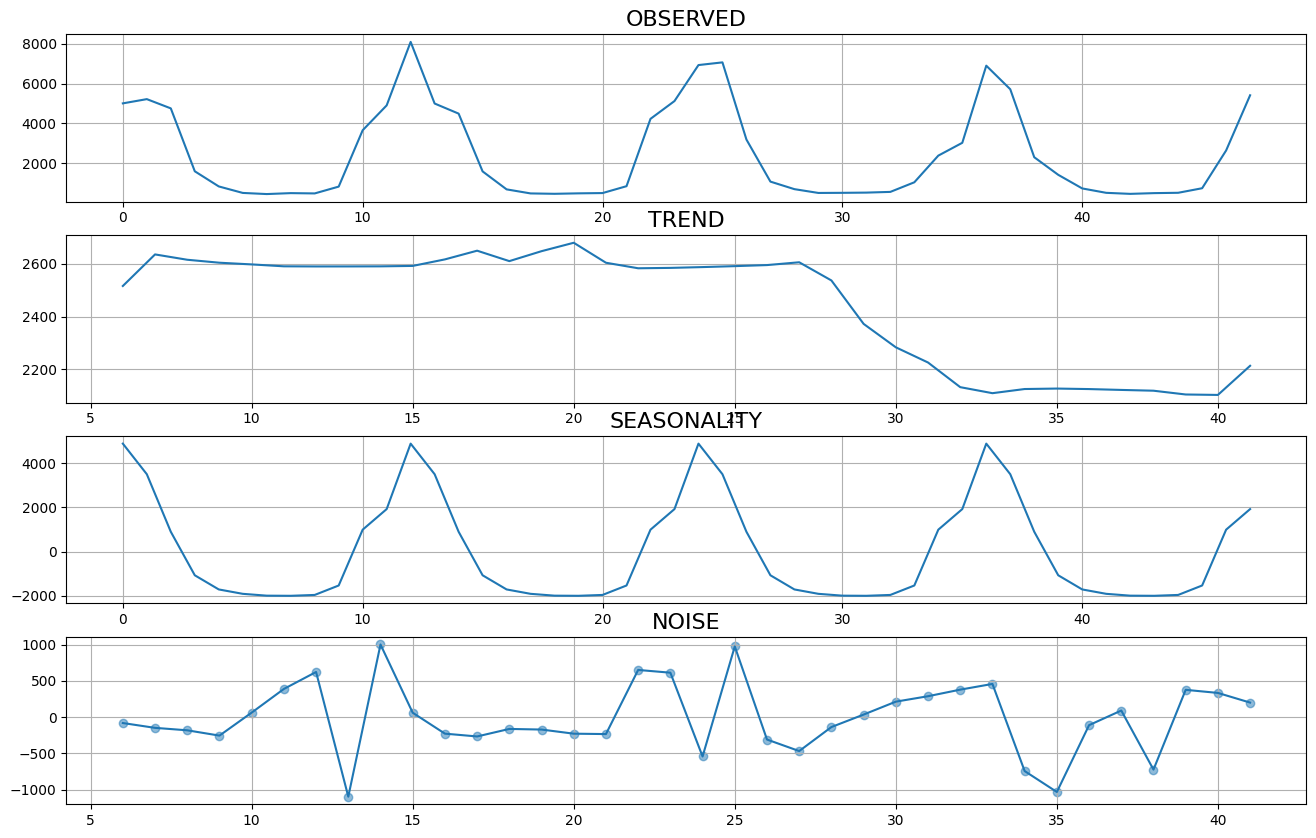

In [403]:
# Decompose Gas demand
%load_ext autoreload
from functions import decompose_ts
%autoreload 2

decompose_ts(df_demand, share_type= "gas_demand_month", samples="all", period=12)

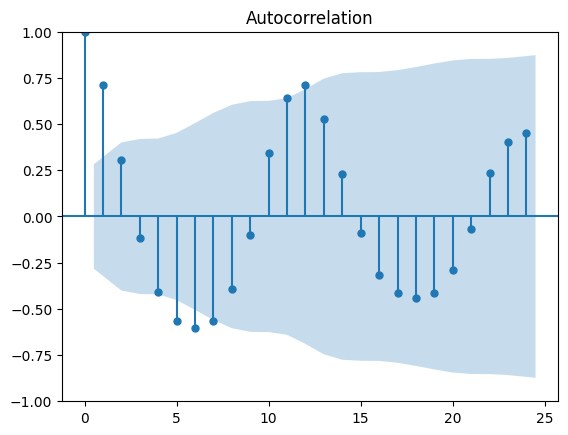

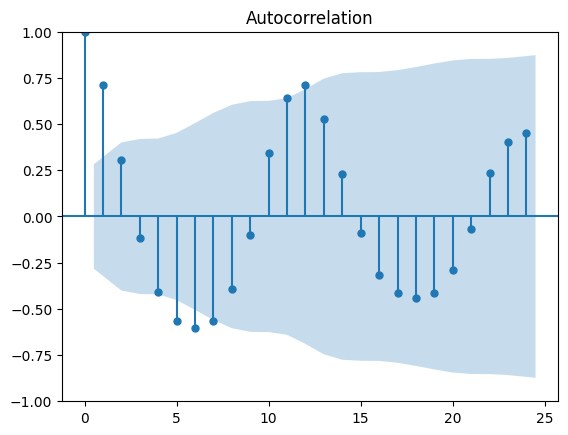

In [404]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_demand["gas_demand_month"].values, lags=24)

In [405]:
# Look at general statistics for gas demand
df_demand.describe()

,gas_demand_month
count,48.000000
mean,2410.791667
std,2303.583212
min,440.000000
25%,502.000000
50%,1049.000000
75%,4553.000000
max,8096.000000


In [406]:
# Convert datetime from object to datetime type
df_demand['datetime'] = pd.to_datetime(df_demand['datetime'])

# Set datetime as index
df_demand = df_demand.set_index(df_demand.datetime)

# Create new column values which are day, month and year.
df_demand['month'] = df_demand["datetime"].dt.month

# Drop datetime column
df_demand.drop('datetime', axis=1, inplace=True)

# Find the mean, median and std of gas_demand_month based on months
monthly_stats = df_demand.groupby('month')['gas_demand_month'].agg(['mean', 'median', 'std'])

# Drop month column
df_demand = df_demand.drop(columns=["month"])

# Print the resulting statistics
print(monthly_stats)

          mean  median          std
month                              
1      6732.00  6914.5  1280.238259
2      5747.25  5464.5   928.393729
3      3678.50  3835.0  1150.225920
4      1410.00  1494.0   243.732093
5       727.50   705.0    67.391889
6       491.75   496.5    13.425722
7       461.25   451.5    27.729347
8       490.75   487.0    15.713582
9       503.75   497.0    32.887434
10      854.00   825.5   126.714903
11     3220.50  3142.0   866.806591
12     4612.25  5010.0  1082.439028


### Temperature

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


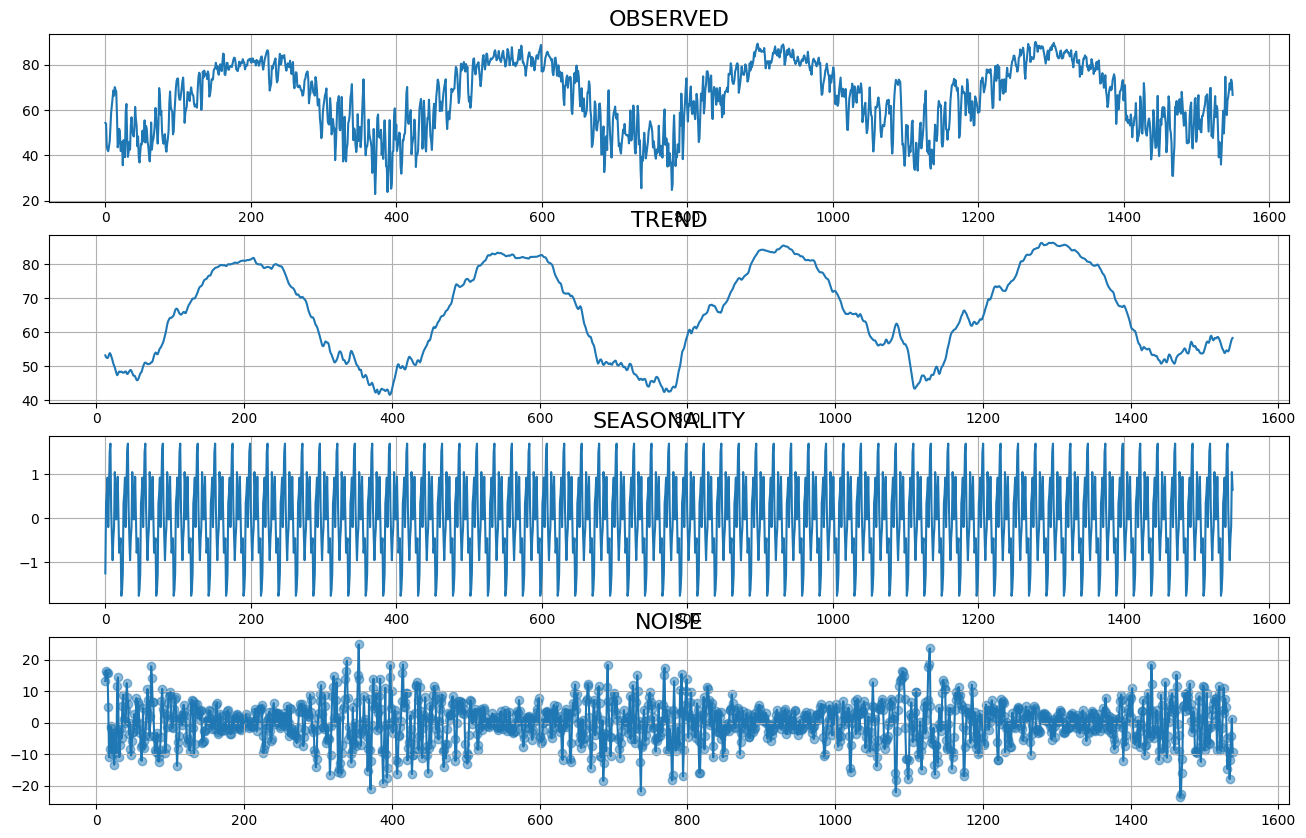

In [407]:
# Decompose temp
%load_ext autoreload
from functions import decompose_ts
%autoreload 2

decompose_ts(df_temp, share_type= "temperature_day", samples="all", period=24)

In [410]:
# Convert datetime from object to datetime type
df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])

# Set datetime as index
df_temp = df_temp.set_index(df_temp.datetime)

# Create new column values which are day, month and year.
df_temp['year'] = df_temp["datetime"].dt.year
df_temp['month'] = df_temp["datetime"].dt.month
df_temp['day'] = df_temp["datetime"].dt.day

# Drop datetime column
df_temp.drop('datetime', axis=1, inplace=True)

# Create cut of date
cut_off_date = pd.to_datetime('2016-12-01')

# Get temp for forecasting
df_temp_future = df_temp[df_temp.index > cut_off_date]

# Cut of the dataframe at 2017-01-01 to match the demand
df_temp = df_temp[df_temp.index <= cut_off_date]

### Combine datasets

In [415]:
# Convert monthly values to daily in gas demand
df_demand = df_demand.resample('D').ffill()
# Merge the datasets based on the common date index
df_combined = df_temp.merge(df_demand, left_on='datetime', right_index=True, how='inner')
# Print dataframe
df_combined

,temperature_day,year,month,day,gas_demand_month
datetime,,,,,
2013-01-01,54.2930,2013,1,1,5003
2013-01-02,53.9276,2013,1,2,5003
2013-01-03,43.8584,2013,1,3,5003
2013-01-04,42.4076,2013,1,4,5003
2013-01-05,41.7938,2013,1,5,5003
...,...,...,...,...,...
2016-11-27,49.5680,2016,11,27,2633
2016-11-28,57.6680,2016,11,28,2633
2016-11-29,71.8520,2016,11,29,2633


## Forecasting

#### Base model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Start date for training: 2013-01-01 00:00:00
End date for training: 2016-08-01 00:00:00
Start date for test: 2016-08-02 00:00:00
End date for test: 2016-12-01 00:00:00
The historical average is: 2446.40718105424


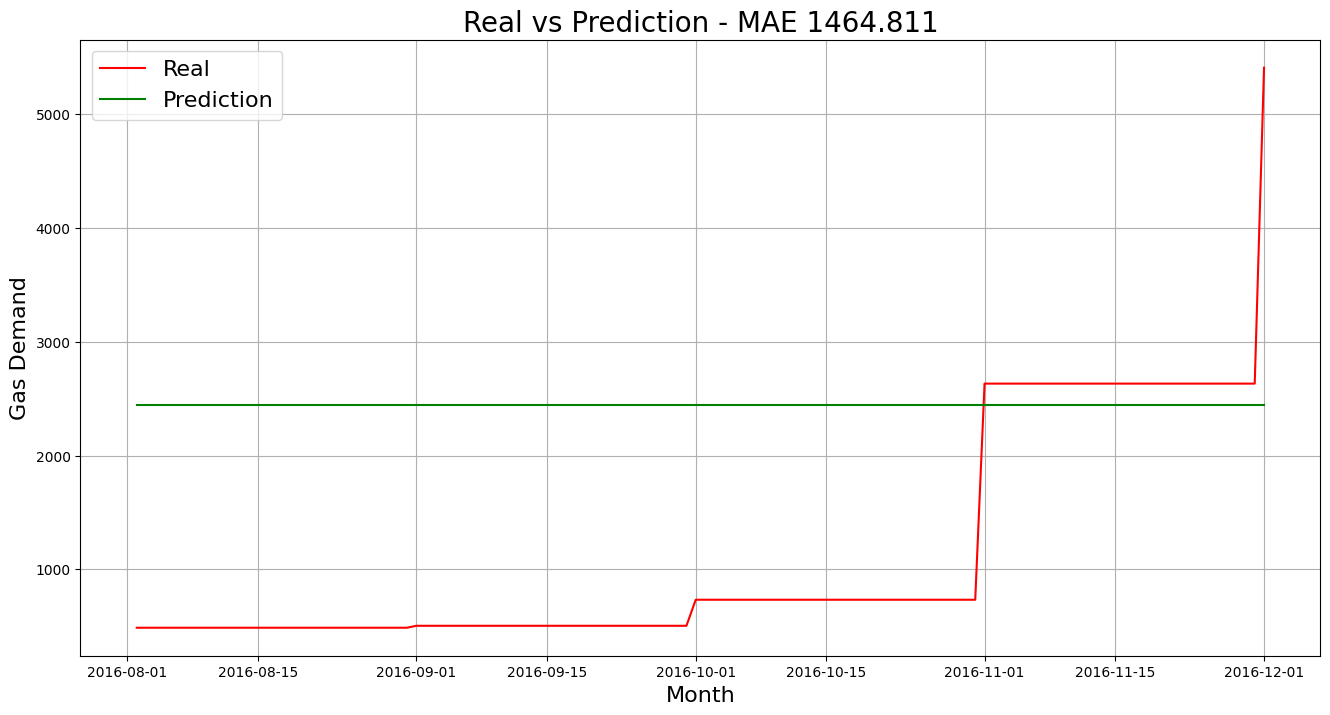

In [416]:
# Plot base model test values for 4 months.
%load_ext autoreload
from functions import train_time_series_with_avg
%autoreload 2
train_time_series_with_avg(df_combined, target_var="gas_demand_month", horizon=122)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Forecasting: 2333.4730957372467


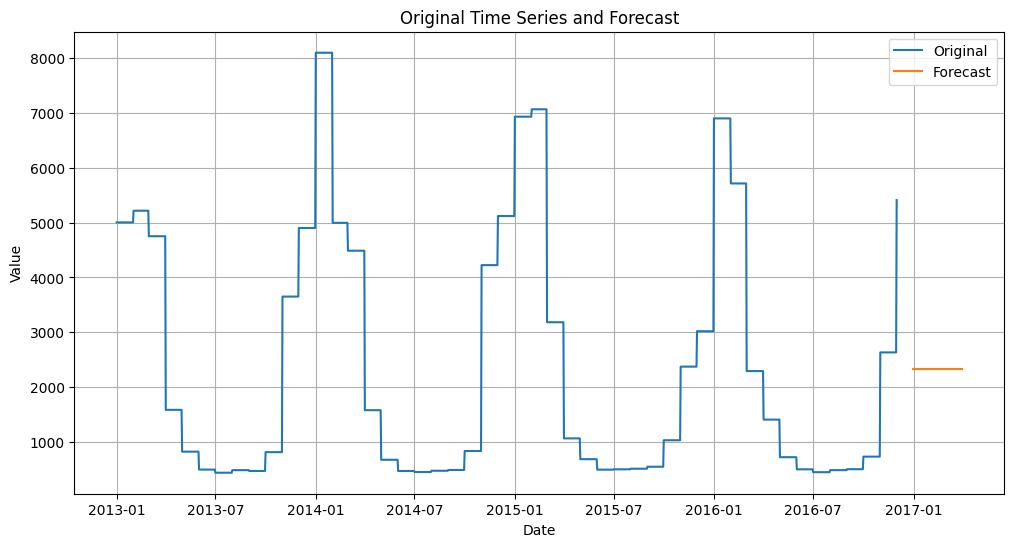

In [417]:
# Make forecast using baseline model
%load_ext autoreload
from functions import average_forecast
%autoreload 2
start_date = '2016-12-02'
end_date = '2017-03-31'
# Generate the forecast using the average method
forecast_df = average_forecast(df_demand, start_date, end_date, target="gas_demand_month")

#### Machine Learning

In [418]:
# Prepare data for machine learning
%load_ext autoreload
from functions import create_lagged_matrix_2
%autoreload 2

# Drop year, month and day variable from df
df_combined = df_combined.drop(columns = ["month", "year", "day"])

# Assuming you have a DataFrame called 'data' containing the target and feature columns
target_column = 'gas_demand_month'
feature_column = 'temperature_day'
lag = 7

X, y = create_lagged_matrix_2(df_combined, target_column, feature_column, lag)

# Display the shapes of X and y
print('X shape:', X.shape)
print('y shape:', y.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X shape: (1424, 7)
y shape: (1424,)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


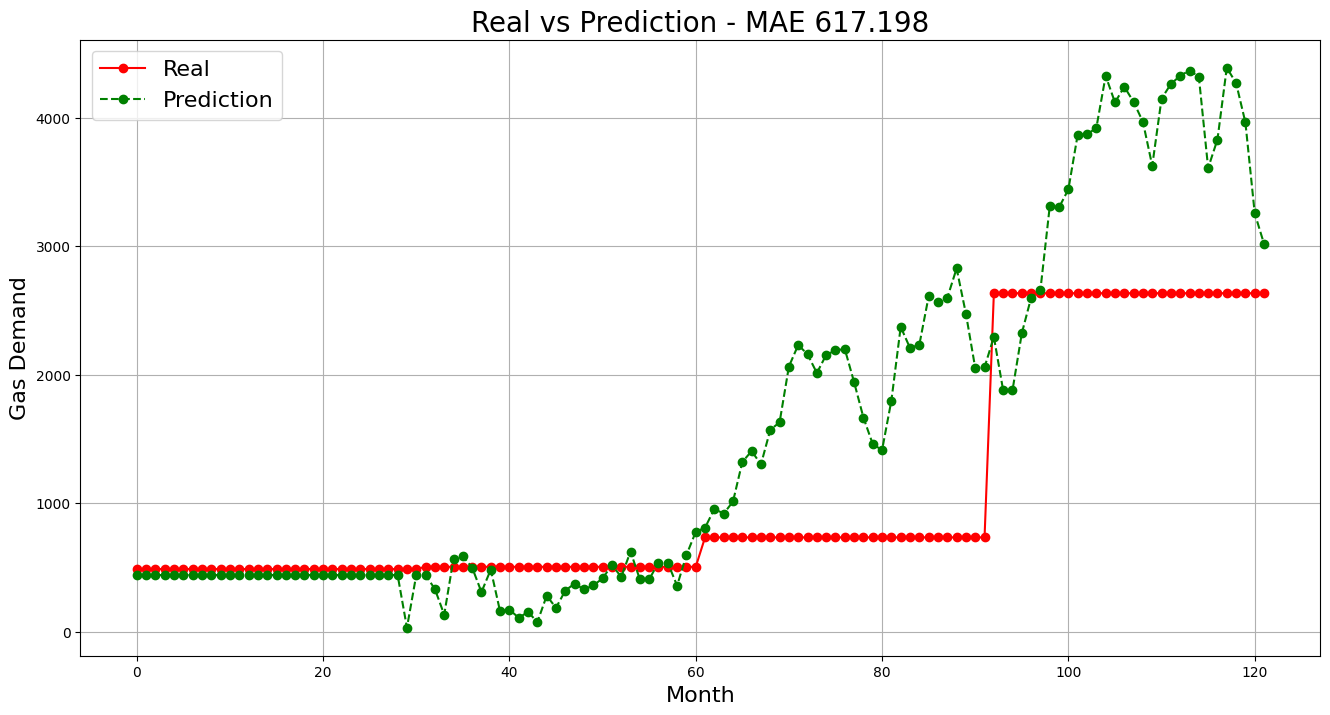

In [419]:
# Train and test on using Linear Regression on 4 months
%load_ext autoreload
from functions import train_time_series_with_linreg
%autoreload 2
model, mae, df_importances = train_time_series_with_linreg(X,y,horizon=122)

In [420]:
# Create lagged values for future temp values
%load_ext autoreload
from functions import create_lagged_matrix_3
%autoreload 2
df_temp_future_lag = create_lagged_matrix_3(df_temp_future,column="temperature_day", lag=7)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DatetimeIndex(['2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16',
               '2016-12-17', '2016-12-18',
               ...
               '2017-03-22', '2017-03-23', '2017-03-24', '2017-03-25',
               '2017-03-26', '2017-03-27', '2017-03-28', '2017-03-29',
               '2017-03-30', '2017-03-31'],
              dtype='datetime64[ns]', length=113, freq='D')


C:\Users\jg\code\templat_reg_and_class\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


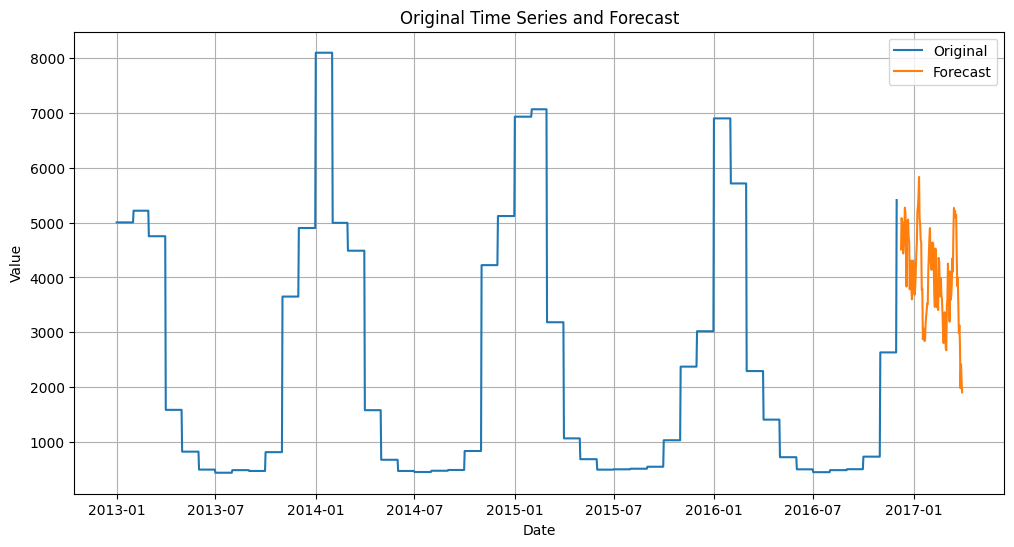

In [427]:
%load_ext autoreload
from functions import plot_forecast
%autoreload 2

# Make forecast values
forecast_values = model.predict(df_temp_future_lag)

# Define start and end date
start_date = '2016-12-09'
end_date = '2017-03-31'

# Create df for forecast values
index = pd.date_range(start=start_date, end=end_date, freq='d')

forecast_df = pd.DataFrame(index=index)

forecast_df['Forecast'] = forecast_values
# Generate the forecast using the average method
forecast_df = plot_forecast(df_demand,forecast_df,target='gas_demand_month')

Trying to model with different lag values. Based on forecast the model with lag_6 features seems to make most sense.